# **Reinforcement Learning: Tarea 1, Estudio comparativo de algoritmos en un problema de k-armed bandit**

## **Autores:** Ana Gil Molina, José María García Ortiz y Levi Malest Villarreal

<br>

**Description:** En esta notebook realizaremos un experimento sobre el *problema del bandido de k brazos* con el que pretendemos comparar el desempeño de distintos algoritmos de las familias *$\varepsilon$-greedy* y *UCB2* en base a estadísticos como el porcentaje de elecciones de brazo óptimas y el *regret* acumulado en función del tiempo.

Para poder interpretar los resultados, se incluyen unas gráficas con sus respectivos análisis y conclusiones al final de la sección **[2]** y **[3]**.

<br>

*This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.*

*For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html*



## **[1] - Preparación del entorno**


In [1]:
#@title **Copiar el repositorio** ``JMGO-coding/k_brazos_GGM``.

!git clone https://github.com/JMGO-coding/k_brazos_GGM.git
!cd k_brazos_GGM/

Cloning into 'k_brazos_GGM'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 603 (delta 64), reused 16 (delta 16), pack-reused 503 (from 1)
Receiving objects: 100% (603/603), 6.87 MiB | 13.20 MiB/s, done.
Resolving deltas: 100% (304/304), done.


In [2]:
#@title **Importamos todas las clases y funciones**

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_GGM')
sys.path.append('/content/k_brazos_GGM/src')

# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

from algorithms import Algorithm, EpsilonGreedy, UCB2
from arms import ArmNormal, Bandit, ArmBinomial, ArmBernoulli
from plotting import plot_optimal_selections, plot_regret

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src']


## **[2] - Experimento**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan varios algoritmos $\varepsilon$-greedy con diferentes valores de $\varepsilon$ y UCB2 con diferentes valores de $\alpha$. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [3]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))

    # Inicializar el regret global acumulado por cada algoritmo
    global_cumulative_regret_per_algo = np.zeros((len(algorithms),steps))

    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        num_choices_list = [[0 for _ in range(len(current_bandit.arms))] for _ in algorithms]   # para almacenar un conteo de las selecciones de cada brazo del bandido para cada algoritmo

        rewards_per_arm = np.zeros((len(algorithms), len(current_bandit.arms)))    # para almacenar las recompensas por cada brazo

        # Ejecutar cada algoritmo
        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                num_choices_list[idx][chosen_arm] += 1   # Actualizamos el conteo del brazo seleccionado en la estapa correspondiente del algoritmo ``algo``

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                rewards_per_arm[idx][chosen_arm] += reward

                global_cumulative_regret_per_algo[idx, step] = q_max*step - total_rewards_per_algo[idx]    # Actualizamos el regret acumulado en cada paso de decisión para cada algoritmo

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100
    proportional_cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    proportional_cumulative_regret_per_algo /= runs
    rewards_per_arm /= runs

    return rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm

### **[2.1] - Ejecución del experimento con Distribución Normal**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 6 algoritmos $\varepsilon$-greedy con $\varepsilon = 0.0, 0.05, 0.1, 0.2, 0.4, 0.7$ y 4 algoritmos UCB2 con $\alpha = 0.1, 0.3, 0.5, 0.9$.

In [6]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k))    # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 6 algoritmos epsilon-greedy con diferentes epsilon y 4 algoritmos UCB2 con distintos alpha.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.05), EpsilonGreedy(k=k, epsilon=0.1),
              EpsilonGreedy(k=k, epsilon=0.2), EpsilonGreedy(k=k, epsilon=0.4), EpsilonGreedy(k=k, epsilon=0.7),
              UCB2(k=k, alpha = 0.1), UCB2(k=k, alpha = 0.3), UCB2(k=k, alpha = 0.5), UCB2(k=k, alpha = 0.9)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu, "std": arm.sigma} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


#### **Visualización de los resultados**

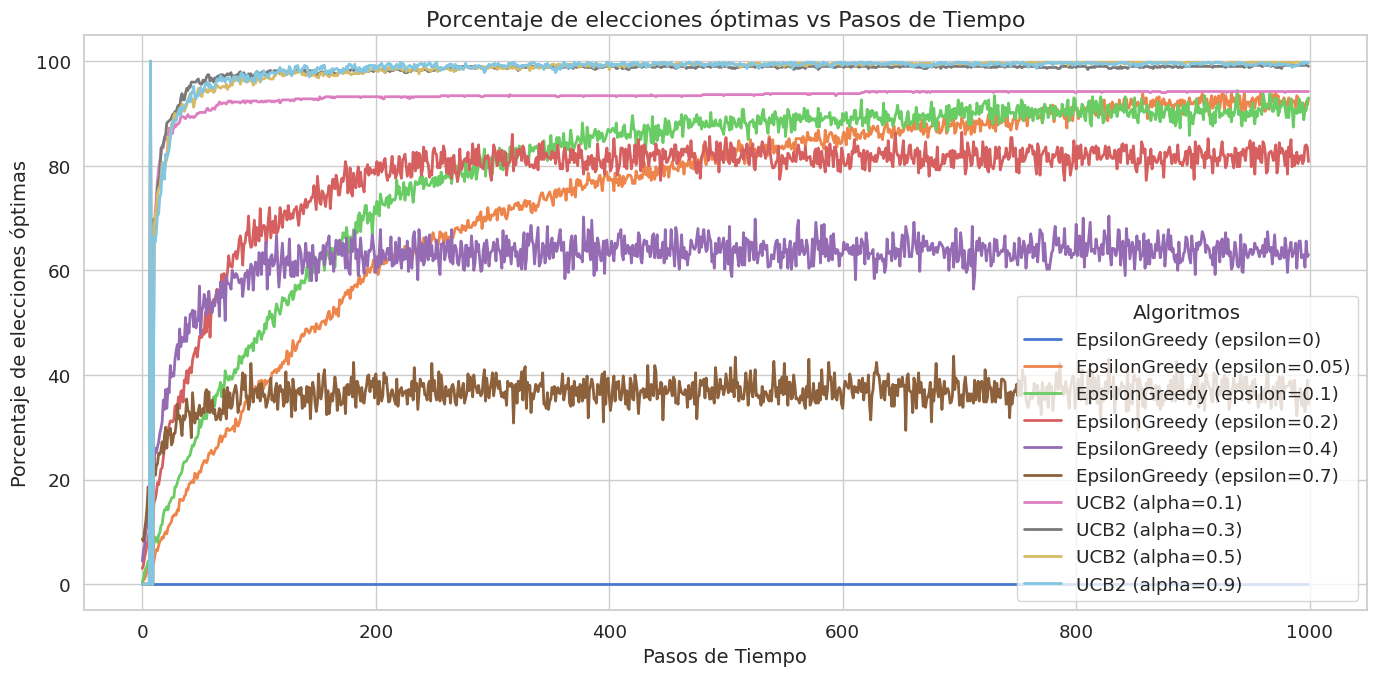

In [7]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### **Análisis detallado de la imagen (1)**

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos UCB2 y $\varepsilon$-greedy consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0$ (línea **azul**) no explora, de forma que su porcentaje de elecciones óptimas se mantiene en un nivel extremadamente bajo, de un $0\%$, ya que no consigue encontrar el mejor brazo, quedándose atrapado en una mala primera elección sin corregirla.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.05$ (línea **naranja**) explora en un $5\%$ de los casos. En este caso, el crecimiento del porcentaje de elecciones óptimas es alto lento en comparación con otros algoritmos. Sin embargo, observamos que con el paso del tiempo, sigue aumentando y finalmente consigue superar a muchos de los demás algoritmos $\varepsilon$-greedy, aunque se queda por debajo de los UCB2.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.1$ (línea **verde**) alcanza algo más rápidamente un porcentaje de elecciones óptimas alto, lo que indica que una estrategia con mayor exploración puede aprender más rápido qué brazos del bandit son óptimos. Además, se estabiliza al alcanzar un porcentaje elevado de elecciones óptimas, pero quedando también por debajo de UCB2.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.2$ (línea **roja**) alcanza más rápidamente un porcentaje de elecciones óptimas alto, pues al realizar una mayor exploración, encuentra antes el brazo óptimo. Sin embargo, se estabiliza al alcanzar un porcentaje de elecciones óptimas algo menor que en el caso de $ε=0.1$.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.4$ (línea **morada**) también crece bastante rápido al principio, pero en poco tiempo deja de crecer, y se estabiliza en un valor más bajo que los algoritmos anteriores, debido a que explora demasiado.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.7$ (línea **marrón**) crece rápido al principio, pero en muy poco tiempo deja de crecer, y se estabiliza en un valor considerablemente más bajo que los algoritmos anteriores, pues explora demasiado o no explota lo suficiente el brazo óptimo. Además, se observa que el porcentaje de elecciones óptimas oscila mucho.
  - El algoritmo UCB2 con **$\alpha=0.1$** (línea **rosa**) muestra un crecimiento del porcentaje de elecciones óptimas más rápido que los algoritmos $\varepsilon$-greedy, y converge en un valor superior al de todos los algoritmos anteriores. Además, se observa una menor oscilación de dicho porcentaje que en el caso de los algoritmos $\varepsilon$-greedy.
  - El algoritmo UCB2 con **$\alpha=0.3$** (línea **gris**) también muestra un crecimiento rápido desde el principio, y se estabiliza en un valor mayor del porcentaje de elecciones óptimas que UCB2 con $\alpha=0.1$. Esto ocurre probablemente porque al aumentar $\alpha$ se permite una mayor exploración mientras se sigue explotando el brazo óptimo.
  - El algoritmo UCB2 con **$\alpha=0.5$** (línea **amarilla**) crece bastante rápido desde el principio, y consigue alcanzar un valor más elevado que los casos anteriores. Con este valor de $\alpha$ se consigue un balance eficiente entre exploración y explotación.
  - El algoritmo UCB2 con **$\alpha=0.9$** (línea **azul claro**) también crece bastante rápido al principio, pero alcanza valores algo menores a los de UCB con $\alpha=0.5$. Esto probablemente se debe a que favorece demasiado la explotación desde el principio, no explorando lo suficiente.

Esta diferencia entre el rendimiento de los algoritmos UCB2 y $\varepsilon$-greedy podría deberse a que UCB2 utiliza una fórmula compleja para balancear exploración y explotación:

$$ UCB2(a) = Q(a) + \sqrt{\frac{(1+\alpha)\ln t}{2\tau(k_a)}}$$

donde $Q(a)$ es la estimación del valor de la acción $a$, $0<\alpha<1$ es un parámetro de ajuste para el balance entre exploración y explotación, $k_a$ es el número de épocas de la acción $a$, y $\tau(k_a) = \lceil (1+\alpha)^{k_a}\rceil$ determina el número de veces que la acción $a$ será seleccionada en una época. Gracias a $\tau(k_a)$, la exploración se vuelve más eficiente, ya que no solo depende de cuántas veces se ha seleccionado el brazo $a$, sino también de las épocas. De esta forma, se actualiza la exploración de forma dinámica, pues se ajusta con el número de épocas, permitiendo que el algoritmo converja más rápido.
  
Sin embargo, el algoritmo $\varepsilon$-greedy sigue una estrategia mucho más sencilla, en la que en cada paso, se emplora con probabilidad $\varepsilon$ y se explota con probabilidad $1-\varepsilon$.

Esto significa que UCB2 ajusta dinámicamente su nivel de exploración según el número de épocas, mientras que la estrategia de exploración de $\varepsilon$-greedy es estática, pues la probabilidad de explorar se fija antes de empezar el experimento, y permanece constante a lo largo del mismo, lo que puede llevar a una exploración innecesaria incluso cuando ya se tiene suficiente información de los distintos brazos. En consecuencia, UCB2 suele ser más eficiente en balancear entre exploración y explotación.

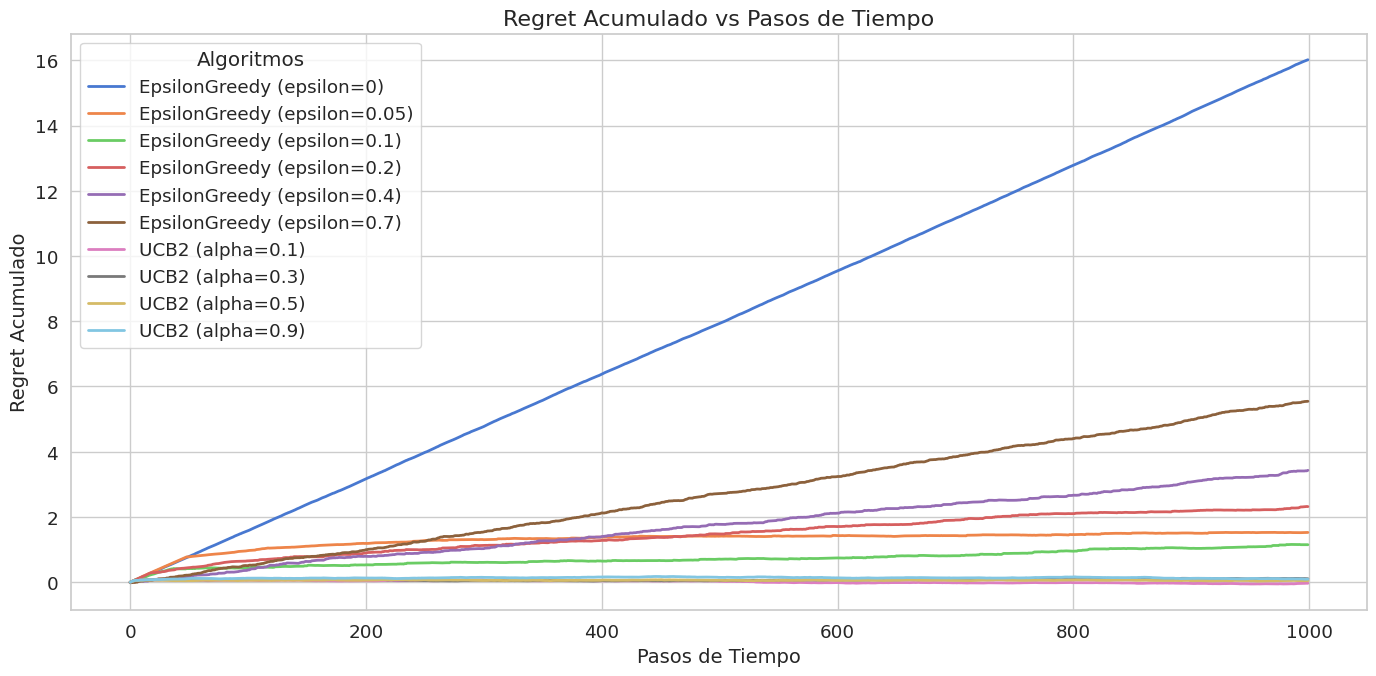

In [8]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

#### **Análisis detallado de la imagen (2)**

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB2** y **$\varepsilon$-greedy** considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - El algoritmo $\varepsilon$-greedy con **ε=0** (línea **azul**) muestra el peor desempeño, pues el regret crece de forma lineal con el tiempo, y con valores mucho mayores que los otros algoritmos. Esto confirma que seguir una estrategia puramente de explotación, sin nada de exploración, lleva a que el algoritmo se quede atrapado en el primer brazo escogido, que puede no ser el óptimo.
  - El algoritmo $\varepsilon$-greedy con **ε=0.05** (línea **naranja**) tiene un desempeño mejor que el anterior. En los primeros pasos, el regret aumenta algo rápido, pero en poco tiempo consigue estabilizarse, consiguiendo finalmente un regret bajo en comparación con otros algoritmos $\varepsilon$-greedy.
  - El algoritmo $\varepsilon$-greedy con **ε=0.1** (línea **verde**) muestra el mejor desempeño de entre todos los algoritmos $ɛ$-greedy estudiados. Este algoritmo consigue descubrir rápidamente el brazo óptimo, reduciendo las pérdidas por elegir opciones subóptimas.
  - El algoritmo $\varepsilon$-greedy con **ε=0.2** (línea **roja**) comienza con un buen desempeño, con un aumento lento del regret, pues consigue descubrir rápidamente el brazo óptimo, pero a lo largo de tiempo, su desempeño es algo peor que con el anterior algoritmo, debido a que explora más de lo necesario, en lugar de centrarse en explotar el brazo óptimo una vez lo encuentra.
  - El algoritmo $\varepsilon$-greedy con **ε=0.4** (línea **morada**) comienza de nuevo con un buen desempeño, con un aumento lento del regret, pero con el paso del tiempo, su desempeño se vuelve considerablemente peor que con algunos de los algoritmos anteriores, pues explora todavía más que dichos algoritmos.
  - El algoritmo $\varepsilon$-greedy con **ε=0.7** (línea **marrón**) tiene un desempeño claramente peor que muchos de los anteriores algoritmos, debido a que explora un 70% de las veces, incluso después de haber descubierto el brazo óptimo.
  - Los algoritmos UCB2 con $\alpha=0.1$ (línea **rosa**), UCB2 con $\alpha=0.3$ (línea **gris**), UCB2 con $\alpha=0.5$ (línea **amarilla**) y UCB2 con $\alpha=0.9$ (línea **azul claro**) muestran todos un desempeño muy similar, con valores de regret acumulado que se mantienen muy cercanos al $0$, por lo que claramente dan resultados mejores que los algoritmos $\varepsilon$-greedy. En particular, $\alpha=0.1$ y $\alpha=0.5$ parecen ser los que mantienen los valores más bajos de regret acumulado al final del experimento.

Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \frac{(\mu_i - \mu^*)^2}{2\sigma^2}$

In [9]:
def I_normal(mu_i, mu_star, sigma_2):
    """Divergencia KL entre dos normales con la misma varianza."""
    return (mu_i - mu_star)**2 / (2 * sigma_2)

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo
sigma_2 = 1          # Varianza de los brazos (igual para todos)

# Calcular la constante
cte = sum((mu_star - mu) / I_normal(mu, mu_star, sigma_2) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-9-e8a6397acd45>:13: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


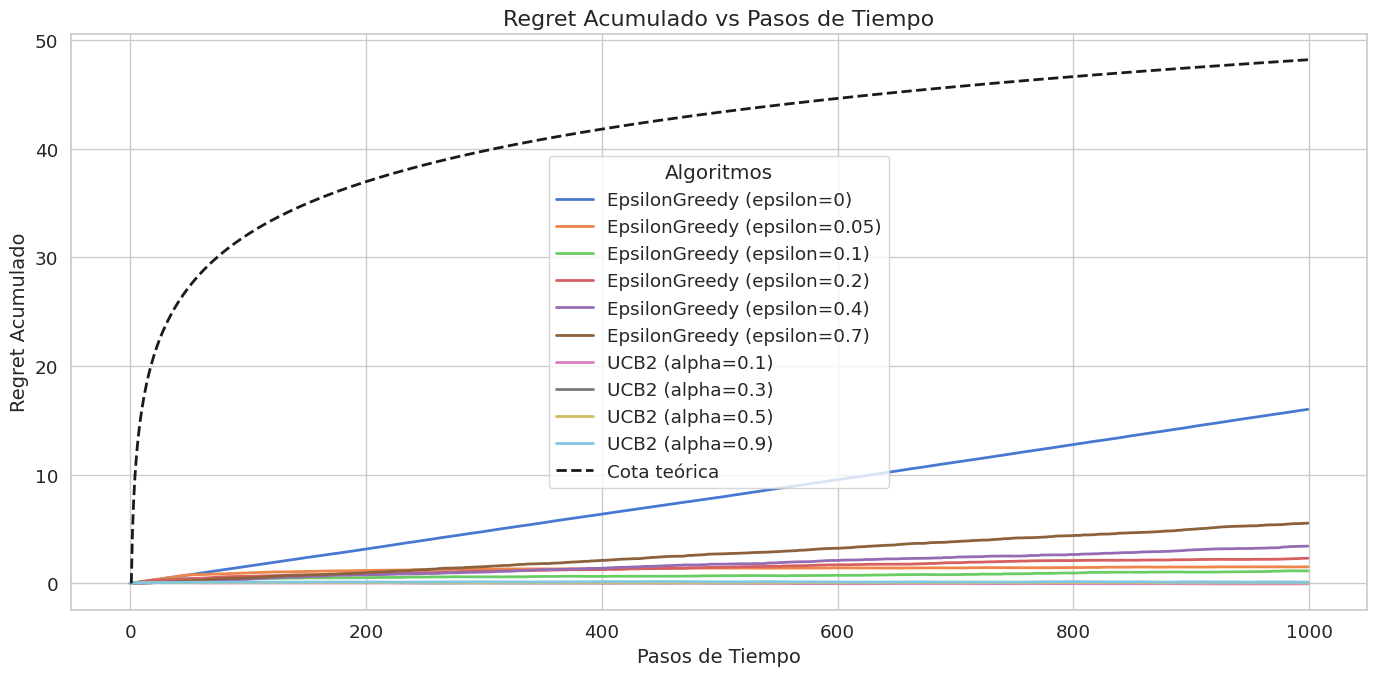

In [10]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

Efectivamente, el regret acumulado se mantiene muy por debajo de la cota teórica con todos los algoritmos UCB2 y $\epsilon$-greedy considerados, mostrando el buen desempeño de dichos algoritmos.

### **[2.2] - Ejecución del experimento con Distribución Bernoulli**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Bernoulli. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 6 algoritmos $\varepsilon$-greedy con $\varepsilon = 0.0, 0.05, 0.1, 0.2, 0.4, 0.7$ y 4 algoritmos UCB2 con $\alpha = 0.1, 0.3, 0.5, 0.9$.

In [11]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k))    # Generar un bandido con k brazos de distribución Bernoulli
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 6 algoritmos epsilon-greedy con diferentes epsilon y 4 algoritmos UCB2 con distintos alpha.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.05), EpsilonGreedy(k=k, epsilon=0.1),
              EpsilonGreedy(k=k, epsilon=0.2), EpsilonGreedy(k=k, epsilon=0.4), EpsilonGreedy(k=k, epsilon=0.7),
              UCB2(k=k, alpha = 0.1), UCB2(k=k, alpha = 0.3), UCB2(k=k, alpha = 0.5), UCB2(k=k, alpha = 0.9)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmBernoulli(p=0.3745401188473625), ArmBernoulli(p=0.9507143064099162), ArmBernoulli(p=0.7319939418114051), ArmBernoulli(p=0.5986584841970366), ArmBernoulli(p=0.15601864044243652), ArmBernoulli(p=0.15599452033620265), ArmBernoulli(p=0.05808361216819946), ArmBernoulli(p=0.8661761457749352), ArmBernoulli(p=0.6011150117432088), ArmBernoulli(p=0.7080725777960455)
Optimal arm: 2 with expected reward=0.9507143064099162


#### **Visualización de los resultados**

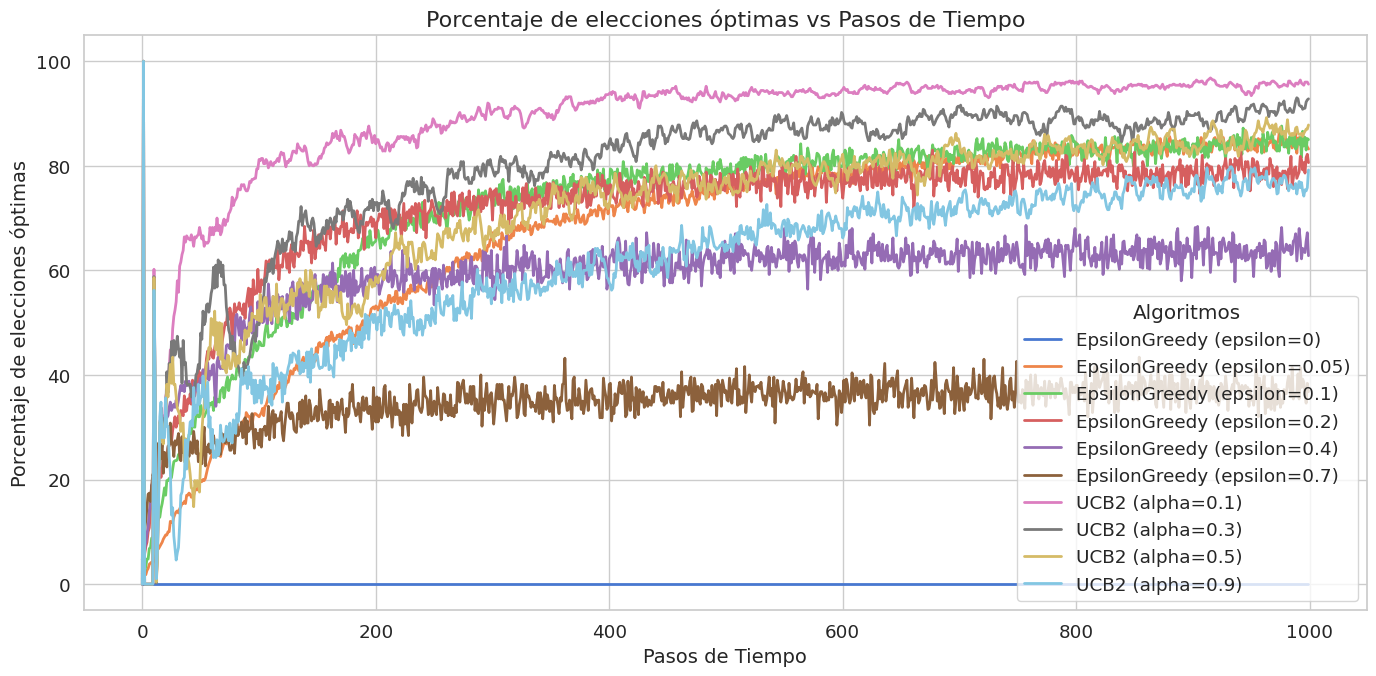

In [12]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### **Análisis detallado de la imagen (1)**

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos UCB2 y $\varepsilon$-greedy consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0$ (línea **azul**) no explora, de forma que su porcentaje de elecciones óptimas se mantiene otra vez en un $0\%$, ya que no consigue encontrar el mejor brazo, quedándose atrapado en una mala primera elección sin corregirla.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.05$ (línea **naranja**) explora en un $5\%$ de los casos. En este caso, el crecimiento del porcentaje de elecciones óptimas es algo más lento que con otros valores de $ɛ$. Sin embargo, observamos que con el paso del tiempo, sigue aumentando y finalmente consigue superar a la mayoría de algoritmos $\varepsilon$-greedy.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.1$ (línea **verde**) alcanza algo más rápidamente un porcentaje de elecciones óptimas alto, lo que de nuevo indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos. Además, se estabiliza al alcanzar un porcentaje elevado de elecciones óptimas, quedando por encima de todos los demás algoritmos $\varepsilon$-greedy.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.2$ (línea **roja**) alcanza más rápidamente un porcentaje de elecciones óptimas alto, pues al realizar una mayor exploración, encuentra antes el brazo óptimo. Sin embargo, se estabiliza al alcanzar un porcentaje de elecciones óptimas algo menor que en el caso de $ε=0.1$.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.4$ (línea **morada**) también crece bastante rápido al principio, pero en poco tiempo deja de crecer, y se estabiliza en un valor más bajo que los algoritmos anteriores, debido a que explora demasiado.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.7$ (línea **marrón**) crece rápido al principio, pero en muy poco tiempo deja de crecer, y se estabiliza en un valor considerablemente más bajo que los algoritmos anteriores, pues explora demasiado o no explota lo suficiente el brazo óptimo. Además, se observa que el porcentaje de elecciones óptimas oscila mucho.
  - El algoritmo UCB2 con **$\alpha=0.1$** (línea **rosa**) muestra un crecimiento del porcentaje de elecciones óptimas más rápido que los algoritmos $\varepsilon$-greedy, y converge en un valor superior al de todos los demás algoritmos. Sin embargo, se observa una oscilación considerable en los primeros pasos del experimento, aunque luego consigue estabilizarse.
  - El algoritmo UCB2 con **$\alpha=0.3$** (línea **gris**) también muestra un crecimiento rápido desde el principio, aunque con bastantes oscilaciones. Sin embargo, luego se estabiliza en un valor mayor que los algoritmos $\varepsilon$-greedy, aunque algo menor que UCB2 con $\alpha=0.1$.
  - El algoritmo UCB2 con **$\alpha=0.5$** (línea **amarilla**) crece algo más lento inicialmente, y oscilando considerablemente, y luego se estabiliza en un valor menor que los casos anteriores, aunque superior que los algoritmos $\varepsilon$-greedy.
  - El algoritmo UCB2 con **$\alpha=0.9$** (línea **azul claro**) inicia oscilando demasiado, y se estabiliza en un valor menor que los otros algoritmos UCB2, y que algunos $\varepsilon$-greedy. Esto probablemente se debe a que favorece demasiado la explotación desde el principio, no explorando lo suficiente.

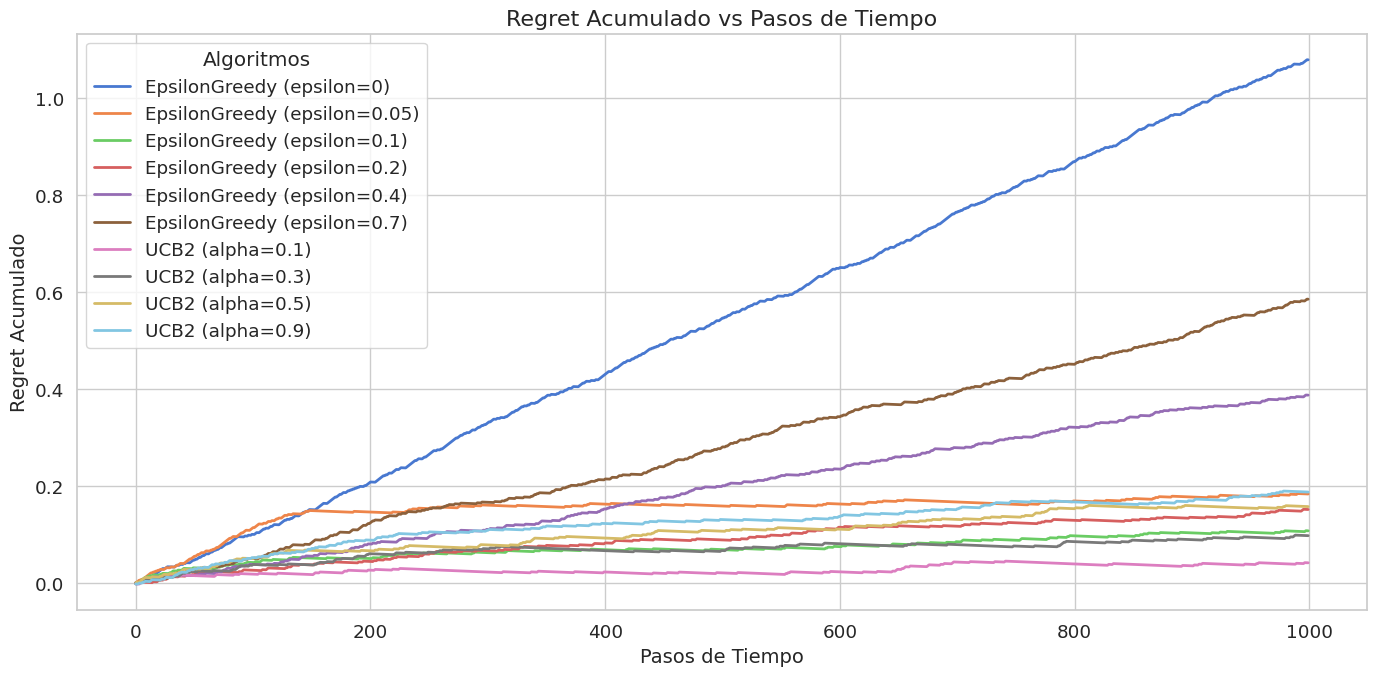

In [13]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

#### **Análisis detallado de la imagen (2)**

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB** considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - El algoritmo UCB1 (línea **azul**) muestra un desempeño intermedio en comparación con los algoritmos $ɛ$-greedy. Sin embargo, los valores que alcanza para el regret acumulado son bastante bajos en general, monstrando un buen desempeño.
  - El algoritmo $\varepsilon$-greedy con **ε=0** (línea **naranja**) muestra el peor desempeño, pues el regret crece consistentemente con el tiempo, y con valores mucho mayores que los otros algoritmos. Esto confirma que seguir una estrategia puramente de explotación, sin nada de exploración, lleva a que el algoritmo se quede atrapado en el primer brazo escogido, que puede no ser el óptimo.
  - El algoritmo $\varepsilon$-greedy con **ε=0.05** (línea **verde**) tiene un desempeño mejor que el caso anterior. En los primeros pasos, el regret aumenta algo rápido, pero en poco tiempo consigue estabilizarse, consiguiendo finalmente un regret bajo en comparación con otros algoritmos.
  - El algoritmo $\varepsilon$-greedy con **ε=0.1** (línea **roja**) muestra el mejor desempeño de entre todos los algoritmos $ɛ$-greedy estudiados. Este algoritmo consigue descubrir rápidamente el brazo óptimo, reduciendo las pérdidas por elegir opciones subóptimas.
  - El algoritmo $\varepsilon$-greedy con **ε=0.2** (línea **morada**) comienza con un buen desempeño, con un aumento lento del regret, pues consigue descubrir rápidamente el brazo óptimo, pero a lo largo de tiempo, su desempeño es algo peor que con el anterior algoritmo, debido a que explora más de lo necesario, en lugar de centrarse en explotar el brazo óptimo una vez lo encuentra. Aún así, es uno de los algoritmos con mejores resultados de los considerados.
  - El algoritmo $\varepsilon$-greedy con **ε=0.4** (línea **marrón**) comienza con un desempeño medianamente bueno, con un aumento lento del regret, pero con el paso del tiempo, su desempeño se vuelve considerablemente peor que con algunos de los algoritmos anteriores, pues explora todavía más que los casos anteriores.
  - El algoritmo $\varepsilon$-greedy con **ε=0.7** (línea **rosa**) tiene un desempeño claramente peor que muchos de los anteriores algoritmos, debido a que explora un 70% de las veces, incluso después de haber descubierto el brazo óptimo.


Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \mu_i \ln \left( \frac{\mu_i}{\mu^*} \right) + (1 - \mu_i) \ln \left( \frac{1 - \mu_i}{1 - \mu^*} \right)$

In [ ]:
def I_bernoulli(mu_i, mu_star):
    """Divergencia KL entre dos Bernoulli."""
    return mu_i * np.log(mu_i / mu_star) + (1 - mu_i) * np.log((1 - mu_i) / (1 - mu_star))

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo

# Calcular la constante
cte = sum((mu_star - mu) / I_bernoulli(mu, mu_star) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-7-14c133996bdd>:12: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


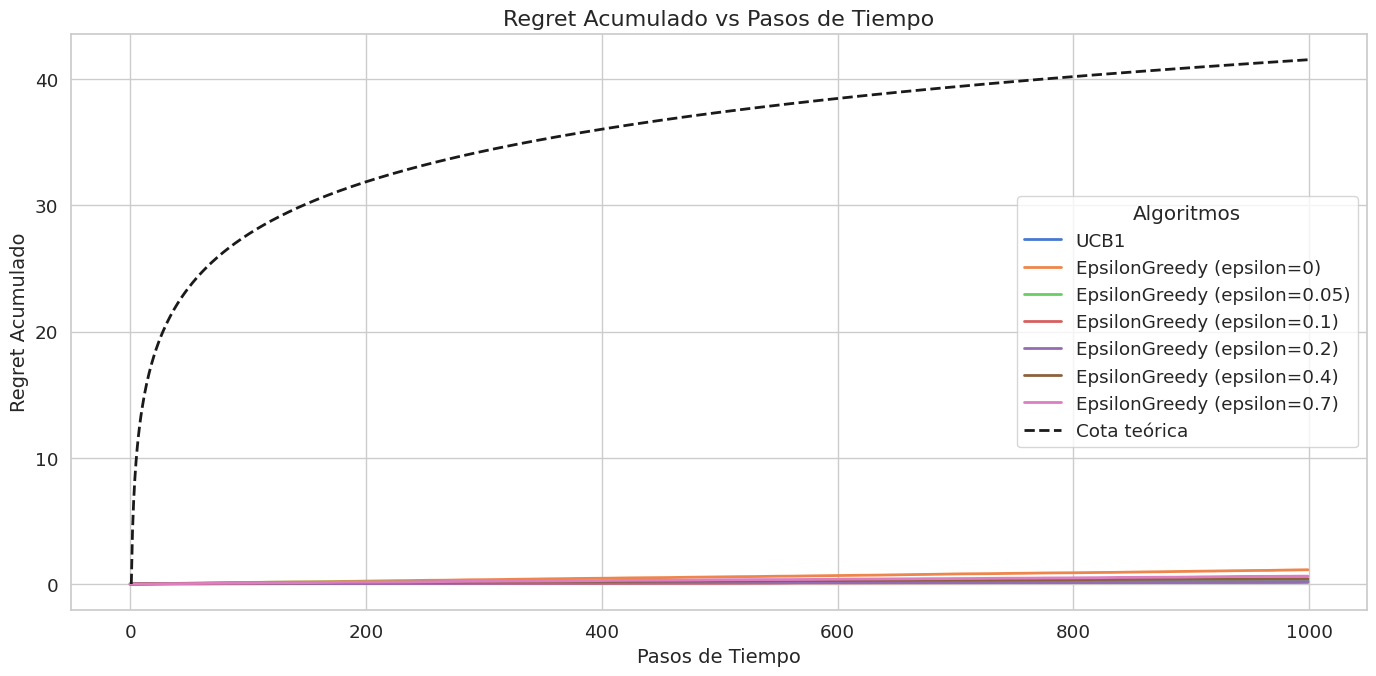

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

De nuevo, el regret acumulado se mantiene muy por debajo de la cota teórica con todos los algoritmos UCB considerados, mostrando el buen desempeño de dichos algoritmos.

### **[2.3] - Ejecución del experimento con Distribución Binomial**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Binomial. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan un algoritmo UCB1 y 6 algoritmos $\varepsilon$-greedy con $\varepsilon = 0.0, 0.05, 0.1, 0.2, 0.4, 0.7$.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k))    # Generar un bandido con k brazos de distribución Binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 1 algoritmo UCB1 y 6 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [UCB1(k=k), EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.05), EpsilonGreedy(k=k, epsilon=0.1),
              EpsilonGreedy(k=k, epsilon=0.2), EpsilonGreedy(k=k, epsilon=0.4), EpsilonGreedy(k=k, epsilon=0.7)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmBinomial(n=20, p=0.21233911067827616), ArmBinomial(n=2, p=0.8661761457749352), ArmBinomial(n=9, p=0.9507143064099162), ArmBinomial(n=8, p=0.5247564316322378), ArmBinomial(n=5, p=0.18340450985343382), ArmBinomial(n=15, p=0.7080725777960455), ArmBinomial(n=1, p=0.9699098521619943), ArmBinomial(n=11, p=0.2912291401980419), ArmBinomial(n=18, p=0.5986584841970366), ArmBinomial(n=4, p=0.15599452033620265)
Optimal arm: 9 with expected reward=10.775852715546659


#### **Visualización de los resultados**

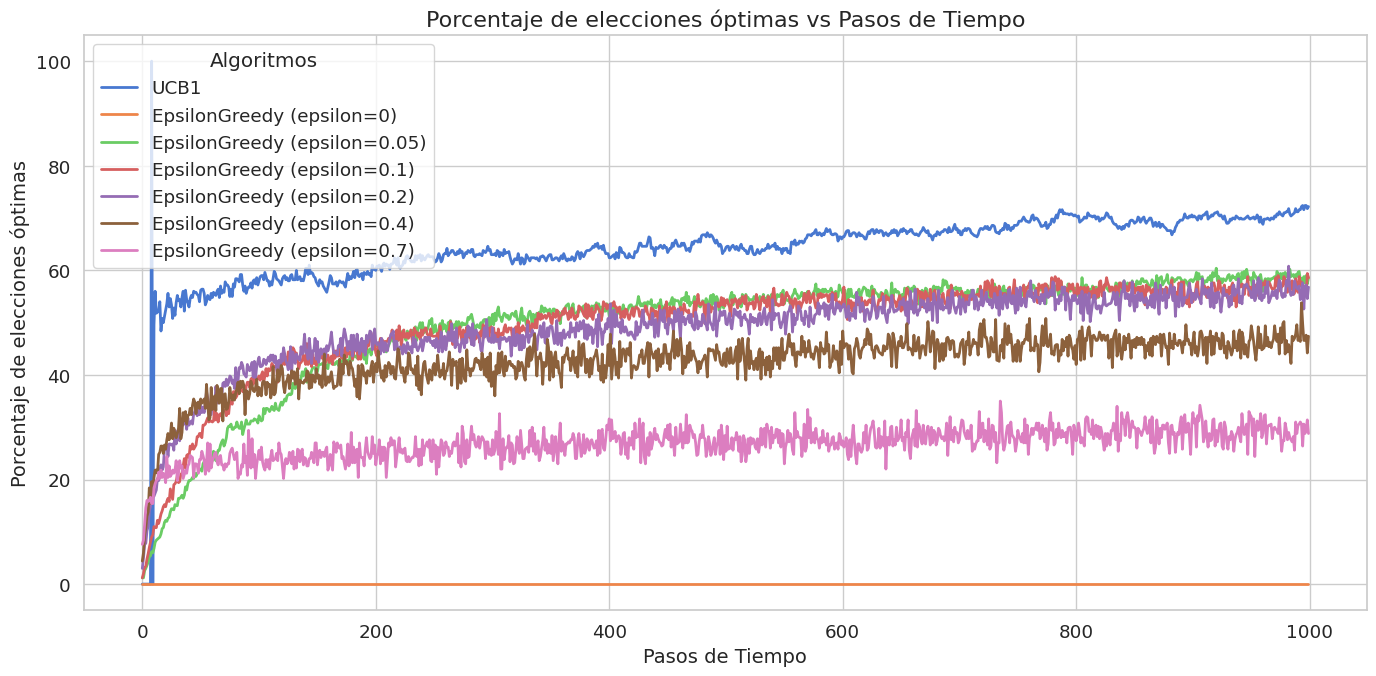

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### **Análisis detallado de la imagen (1)**

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos UCB1 y $\varepsilon$-greedy consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo UCB1 (línea **azul**) muestra un crecimiento del porcentaje de elecciones óptimas mucho más rápido que los algoritmos $\varepsilon$-greedy. Además, los valores que logra alcanzar son más elevados que los otros algoritmos.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0$ (línea **naranja**) no explora, de forma que su porcentaje de elecciones óptimas se mantiene otra vez en un $0\%$, ya que no consigue encontrar el mejor brazo, quedándose atrapado en una mala primera elección sin corregirla.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.05$ (línea **verde**) explora en un $5\%$ de los casos. En este caso, el crecimiento del porcentaje de elecciones óptimas es algo más lento que con otros valores de $ɛ$. Sin embargo, observamos que con el paso del tiempo, sigue aumentando y finalmente consigue superar al resto de algoritmos $\varepsilon$-greedy, aunque queda por debajo del UCB1.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.1$ (línea **roja**) alcanza algo más rápidamente un porcentaje de elecciones óptimas alto, lo que de nuevo indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos. Además, se estabiliza al alcanzar un porcentaje elevado de elecciones óptimas, quedando por encima de casi todos los demás algoritmos $\varepsilon$-greedy.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.2$ (línea **morada**) alcanza más rápidamente un porcentaje de elecciones óptimas alto, pues al realizar una mayor exploración, encuentra antes el brazo óptimo. Sin embargo, se estabiliza al alcanzar un porcentaje de elecciones óptimas ligeramente menor que en el caso de $ε=0.1$.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.4$ (línea **marrón**) también crece bastante rápido al principio, pero en poco tiempo deja de crecer, y se estabiliza en un valor más bajo que los algoritmos anteriores, debido a que explora demasiado.
  - El algoritmo $\varepsilon$-greedy con $\varepsilon=0.7$ (línea **rosa**) crece rápido al principio, pero en muy poco tiempo deja de crecer, y se estabiliza en un valor considerablemente más bajo que los algoritmos anteriores, pues explora demasiado o no explota lo suficiente el brazo óptimo. Además, se observa que el porcentaje de elecciones óptimas oscila mucho.

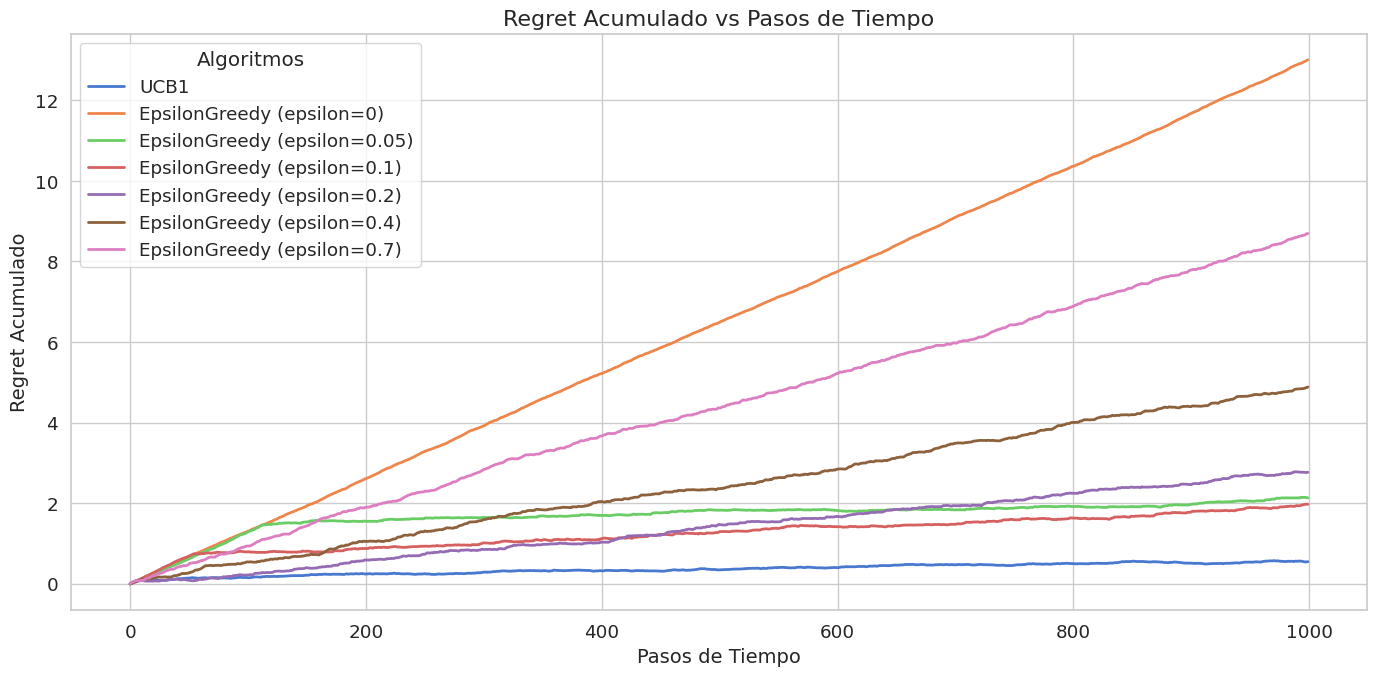

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

#### **Análisis detallado de la imagen (2)**

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB1** y **$\varepsilon$-greedy** considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - El algoritmo UCB1 (línea **azul**) es el que muestra el mejor desempeño de todos para el regret acumulado, probablemente debido a que es capaz de balancear de forma más eficiente que $\varepsilon$-greedy entre exploración y explotación, pues tiene una estrategia más dinámica de balance.
  - El algoritmo $\varepsilon$-greedy con **ε=0** (línea **naranja**) muestra el peor desempeño, pues el regret crece consistentemente con el tiempo, y con valores mucho mayores que los otros algoritmos. Esto de nuevo confirma que seguir una estrategia puramente de explotación, sin nada de exploración, lleva a que el algoritmo se quede atrapado en el primer brazo escogido, que puede no ser el óptimo.
  - El algoritmo $\varepsilon$-greedy con **ε=0.05** (línea **verde**) tiene un desempeño mejor que el caso anterior. En los primeros pasos, el regret aumenta algo rápido, pero en poco tiempo consigue estabilizarse, consiguiendo finalmente un regret bajo en comparación con otros algoritmos.
  - El algoritmo $\varepsilon$-greedy con **ε=0.1** (línea **roja**) muestra el mejor desempeño de entre todos los algoritmos $ɛ$-greedy estudiados. Este algoritmo consigue descubrir rápidamente el brazo óptimo, reduciendo las pérdidas por elegir opciones subóptimas.
  - El algoritmo $\varepsilon$-greedy con **ε=0.2** (línea **morada**) comienza con un buen desempeño, con un aumento lento del regret, pues consigue descubrir rápidamente el brazo óptimo, pero a lo largo de tiempo, su desempeño es algo peor que con el anterior algoritmo, debido a que explora más de lo necesario, en lugar de centrarse en explotar el brazo óptimo una vez lo encuentra. Aún así, es uno de los algoritmos con mejores resultados de los considerados.
  - El algoritmo $\varepsilon$-greedy con **ε=0.4** (línea **marrón**) comienza con un desempeño medianamente bueno, con un aumento lento del regret, pero con el paso del tiempo, su desempeño se vuelve considerablemente peor que con algunos de los algoritmos anteriores, pues explora todavía más que los casos anteriores.
  - El algoritmo $\varepsilon$-greedy con **ε=0.7** (línea **rosa**) tiene un desempeño claramente peor que muchos de los anteriores algoritmos, debido a que explora un 70% de las veces, incluso después de haber descubierto el brazo óptimo.


Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución binomial: $I(p_i, p^*) = n_i \left[ p_i \ln \left( \frac{p_i}{p^*} \right) + (1 - p_i) \ln \left( \frac{1 - p_i}{1 - p^*} \right) \right] + n^* \left[ p^* \ln \left( \frac{p^*}{p_i} \right) + (1 - p^*) \ln \left( \frac{1 - p^*}{1 - p_i} \right) \right]$

In [ ]:
def I_binomial(n_i, n_star, p_i, p_star):
    """Divergencia KL entre dos Binomiales B(n_i, p_i) y B(n_star, p_star)."""
    term1 = n_i * (p_i * np.log(p_i / p_star) + (1 - p_i) * np.log((1 - p_i) / (1 - p_star)))
    term2 = n_star * (p_star * np.log(p_star / p_i) + (1 - p_star) * np.log((1 - p_star) / (1 - p_i)))

    return term1 + term2

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo
ns = [arm.n for arm in bandit.arms]
n_star = max(ns)
ps = [arm.p for arm in bandit.arms]
p_star = max(ps)

# Calcular la constante
cte = sum((mu_star - mus[i]) / I_binomial(ns[i], n_star, ps[i], p_star) for i in range(len(mus)) if mus[i] < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-12-909619a28c65>:16: RuntimeWarning: divide by zero encountered in scalar divide
  cte = sum((mu_star - mus[i]) / I_binomial(ns[i], n_star, ps[i], p_star) for i in range(len(mus)) if mus[i] < mu_star)
<ipython-input-12-909619a28c65>:19: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])
<ipython-input-12-909619a28c65>:19: RuntimeWarning: invalid value encountered in multiply
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


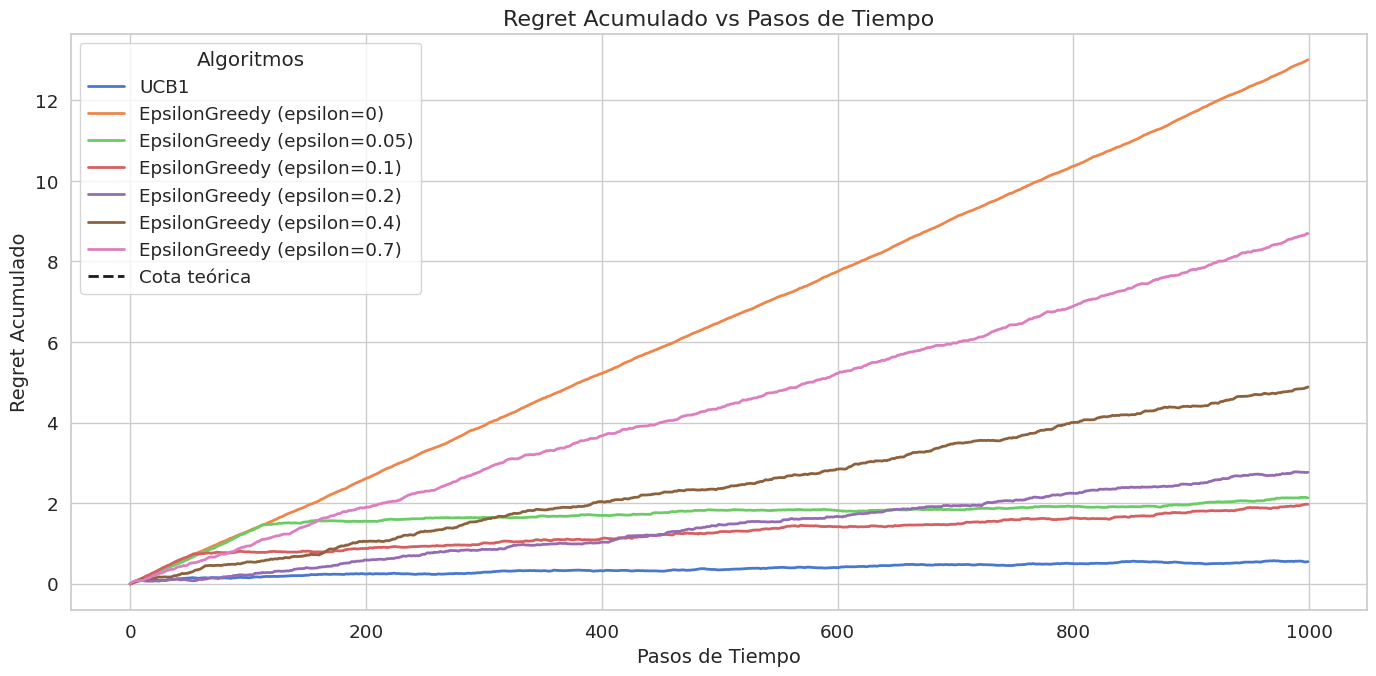

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

In [ ]:
theoretical_bound

array([-inf,  nan,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  i

La cota teórica sale infinito, por lo que en cualquier caso, el regret acumulado obtenido por cualquiera de los algoritmos va a estar por debajo de esta cota.

## **[3] - Conclusiones de este estudio**

Mejores resultados según el estadístico seleccionado y según la distribución elegida para los brazos

| Distribución de los brazos | Porcentaje de elecciones de brazo óptimas en el último paso | Regret acumulado en el último paso |
|:---------:|:---------:|:---------:|
| Normal  | UCB1, $\varepsilon$-greedy ($\varepsilon=0.1$)  | UCB1, $\varepsilon$-greedy ($\varepsilon=0.1$)  |
| Bernoulli  | $\varepsilon$-greedy ($\varepsilon=0.1$) , $\varepsilon$-greedy ($\varepsilon=0.05$)  | $\varepsilon$-greedy ($\varepsilon=0.1$) , $\varepsilon$-greedy ($\varepsilon=0.2$)  |
| Binomial  | UCB1, $\varepsilon$-greedy ($\varepsilon=0.05$)   | UCB1, $\varepsilon$-greedy ($\varepsilon=0.1$) |




Como conclusión podemos determinar que, sorprendentemente, al cambiar la distribución de los brazos del bandido, el algoritmo que mejor desempeño ofrece también cambia. Sin embargo, en este caso, a diferencia de en otros experimentos realizados, vemos que hay ciertos algorimos que en general suelen presentar un mejor desempeño con varias de las distribuciones y métricas consideradas.

Por ejemplo, el algortimo $\varepsilon$-greedy con $\varepsilon=0.1$ ha resultado ser uno de los dos mejores algoritmos para todas las distribuciones de los brazos, excepto en el caso de la Binomial usando como métrica el porcentaje de elecciones de brazo óptimas. Esto nos indica que este algoritmo con este valor de $\varepsilon$ logra un buen balance entre exploración, para buscar el brazo óptimo, y explotación, para explotarlo una vez encontrado.

Otro algoritmo que muestra buenos resultados es el UCB1, especialmente con las distribuciones Normal y Binomial. Sin embargo, con la distribución Bernoulli parece tener ciertas dificultades. Creemos que esto podría deberse a que Bernoulli es una distribución discreta, en la que la recompensa solo puede ser 1 (éxito), con probabilidad $p$, y 0 (fracaso) con probabilidad $1-p$. Esta naturaleza binaria puede provocar que la estimación inicial de la media del brazo fluctúe bruscamente en las primeras iteraciones. Por ejemplo, si en la primera tirada obtienes un $1$, y en la segunda un $0$, la media baja repentinamente de $1$ a $0.5$. Estas oscilaciones iniciales pueden engañar al UCB1, llevándolo a sobreexplotar brazos subóptimos que obtuvieron recompensas altas de casualidad.

En cambio, con las distribuciones Normal y Binomial, las recompensas pueden tomar más valores posibles (no solo 0 o 1), lo que hace que las medias estimadas fluctúen menos y se estabilicen más rápido, permitiendo que UCB1 identifique con mayor precisión el brazo óptimo.

